Arbitrage-free SVI volatility surfaces. Jim Gatheral, Antoine Jacquier

Reference : https://arxiv.org/pdf/1204.0646.pdf



In this colab, we will :    


1.   Generate an IV surface
2.   Calibrate SVI
3.   Generate a local vol surface
4.   Create an interpolation function for local volatilities
5.   Conduct arbitrage tests



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton
import scipy.stats as st
import scipy.optimize as opt
import pandas as pd
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
import seaborn as sns
sns.set()
import plotly.graph_objects as go
import plotly.express as px

IN THIS PART WE WILL WORK WITH A DUMP GENERATED MATRIX

# Generating dump matrix

In [ ]:
def generate_smile_dump_vol_matrix(spot,k_max,k_min,mat_max,mat_min):
  strikes = np.linspace(k_min,k_max,10)
  maturity = np.linspace(mat_min,mat_max,12)
  maturity = maturity/365
  moneyness = np.log(strikes/spot)
  vol_matrix = np.zeros((len(maturity), len(strikes)))
  for i in range(vol_matrix.shape[0]):
    for j in range(vol_matrix.shape[1]):
      t = maturity[i]
      k = moneyness[j]
      vol_matrix[i][j] = np.maximum(0.1, 0.2 - 0.1 * np.abs(t - 0.5) - 0.2 * np.abs(k) + 0.05 * np.abs(t - 0.5) * np.abs(k))
  return vol_matrix

In [ ]:
def generate_flat_dump_vol_matrix(spot,k_max,k_min,mat_max,mat_min, cst_vol):
  strikes = np.linspace(k_min,k_max,10)
  maturity = np.linspace(mat_min,mat_max,12)
  maturity = maturity/365
  moneyness = np.log(strikes/spot)
  vol_matrix = np.zeros((len(maturity), len(strikes)))
  for i in range(vol_matrix.shape[0]):
    for j in range(vol_matrix.shape[1]):
      vol_matrix[i][j] = cst_vol
  return vol_matrix

In [ ]:
def plot_dump_vol_surface(matrix,k_max,k_min,mat_max,mat_min):

  strikes = np.linspace(k_min,k_max,10)
  maturity = np.linspace(mat_min,mat_max,12)
  maturity = maturity/365
  moneyness = np.log(strikes/spot)
  X, Y = np.meshgrid(moneyness, maturity)

  # Plotting the volatility surface
  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot(111, projection='3d')

  # Plotting the surface
  surf = ax.plot_surface(X, Y, vol_matrix, cmap='viridis', edgecolor='k')
  ax.set_xlabel('Moneyness (log(K/S))')
  ax.set_ylabel('Maturity (Years)')
  ax.set_zlabel('Volatility')
  ax.set_title('Volatility Surface')

  # Adding color bar
  fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

  # Show plot
  plt.show()

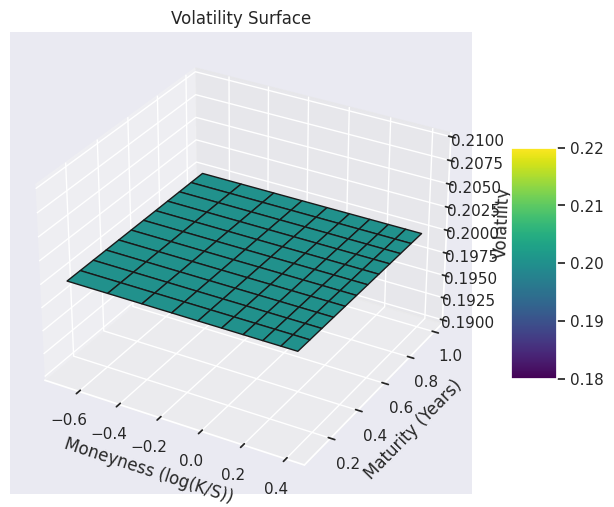

In [ ]:
spot = 100
k_max = 150
k_min = 50
mat_max = 365
mat_min = 30
cst_vol = 0.2
vol_matrix = generate_flat_dump_vol_matrix(spot,k_max,k_min,mat_max,mat_min, cst_vol)
plot_dump_vol_surface(vol_matrix,k_max,k_min,mat_max,mat_min)

# Putting the vol matrix inside a DataFrame

In [ ]:
def generate_flat_vol_dataframe(spot, k_max, k_min, mat_max, mat_min,flat_vol):
    strikes = np.linspace(k_min, k_max, 50)
    maturity = np.linspace(mat_min, mat_max, 12) / 365
    moneyness = np.log(strikes / spot)
    vol_matrix = np.full((len(maturity), len(strikes)), flat_vol)
    moneyness_list = []
    maturity_list = []
    iv_list = []

    # Iterate through the volatility matrix and populate lists
    for i in range(len(maturity)):
        for j in range(len(strikes)):
            t = maturity[i]
            k = moneyness[j]
            iv = vol_matrix[i, j]
            moneyness_list.append(k)
            maturity_list.append(t)
            iv_list.append(iv)

    # Create a DataFrame from lists
    df = pd.DataFrame({
        'Log_Moneyness': moneyness_list,
        'Maturity': maturity_list,
        'IV': iv_list
    })

    return df

In [ ]:
spot = 100
k_max = 150
k_min = 50
mat_max = 365
mat_min = 30
cst_vol = 0.2
df= generate_flat_vol_dataframe(spot, k_max, k_min, mat_max, mat_min,cst_vol)

In [ ]:
data_calls  = df

In [ ]:
data_calls

,Log_Moneyness,Maturity,IV
0,-0.693147,0.082192,0.2
1,-0.653142,0.082192,0.2
2,-0.614676,0.082192,0.2
3,-0.577634,0.082192,0.2
4,-0.541916,0.082192,0.2
...,...,...,...
595,0.349506,1.000000,0.2
596,0.363792,1.000000,0.2
597,0.377877,1.000000,0.2
598,0.391766,1.000000,0.2


#Calibrating the SVI to dump vol matrix

In [ ]:
def SVI(x,a,b,rho,m,s):
  # x : moneyness
  # result : iv**2
  return (a+b*(rho*(x-m)+np.sqrt((x-m)**2+s**2)))
def Calibration(iv,x,init_ms,method_name,maxiter=1,epsilon=10**(-12)):
    opt_rmse = 1
    def svi_transformed(y,a,d,c):
      # y = (x-m)/s
      return a+d*y+c*np.sqrt(y**2 + 1)
    def svi_transformed_loss(iv,y,a,d,c):
      return np.sqrt(np.mean((svi_transformed(y,a,d,c) - iv)**2))
    def calculate_adc(iv,x,_m,_s):
      # position of parameters : a, d, c
      y = (x - _m)/_s
      h = max(_s,10**(-7))
      bounds = ((0,0,0),(max(max(iv),10**(-7)),4*h,4*h))
      z = np.sqrt(y**2 + 1)
      A = np.column_stack([np.ones(len(iv)),y,z])
      a,d,c = opt.lsq_linear(A,iv,bounds,tol=10**(-9),verbose=False).x
      return a,d,c
    def transformed_to_raw(parameters):
      a,d,c,m,s = parameters
      return [a,c/s,d/c,m,s]
    def ms_loss(ms):
      _m,_s = ms
      _y = (x-_m)/_s
      _a,_d,_c = calculate_adc(iv,x,_m,_s)
      return np.sum((_a + _d*_y + _c*np.sqrt(_y**2 + 1) - iv)**2)

    for i in range(1,maxiter + 1):
      m_opt,s_opt = opt.minimize(ms_loss,init_ms,method = method_name, tol = 10**(-8)).x

      a_opt,d_opt,c_opt = calculate_adc(iv,x,m_opt,s_opt)
      opt_rmse1 = svi_transformed_loss(iv,(x-m_opt)/s_opt,a_opt,d_opt,c_opt)
      if i>1 and (abs(opt_rmse - opt_rmse1)<epsilon):
        break
      opt_rmse = opt_rmse1
      init_ms = [m_opt,s_opt]
    result = np.array([a_opt,d_opt,c_opt,m_opt,s_opt])
    opt_parameters = transformed_to_raw(result)
    return opt_parameters

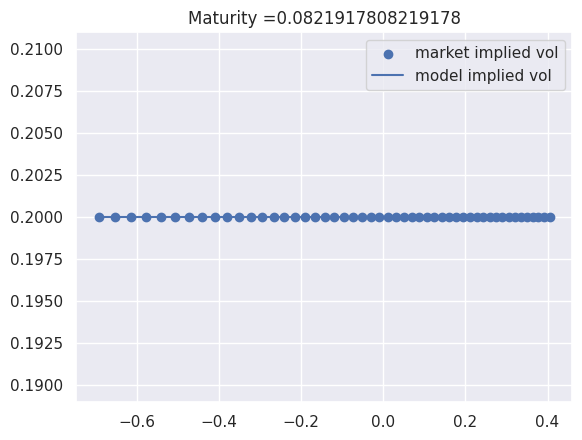

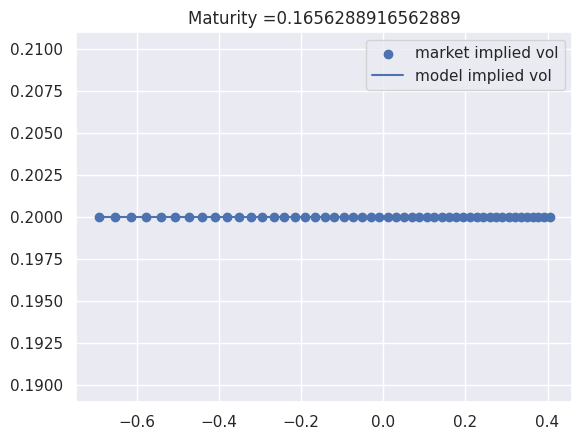

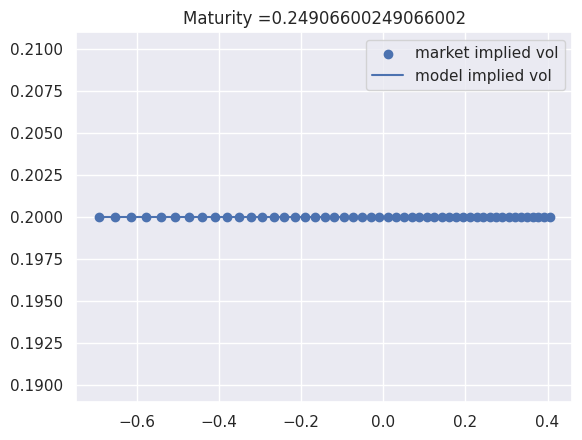

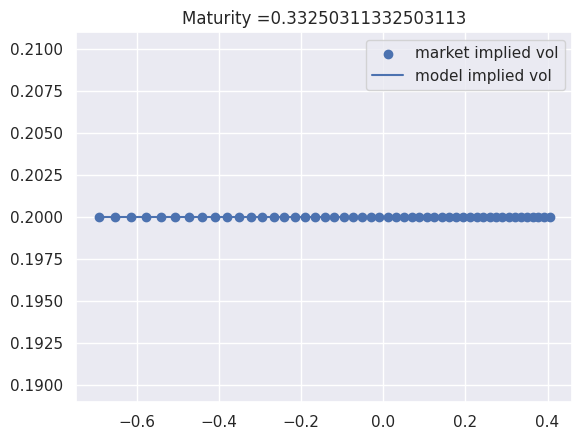

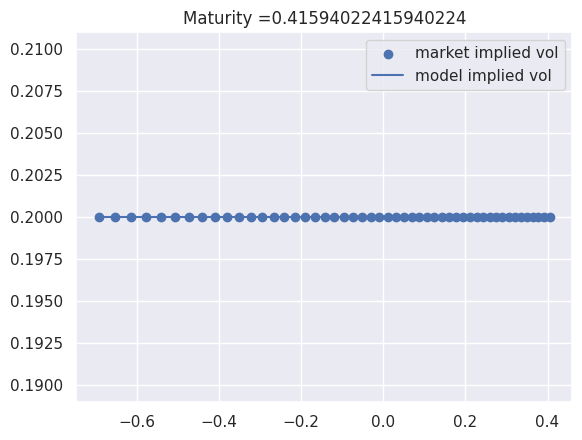

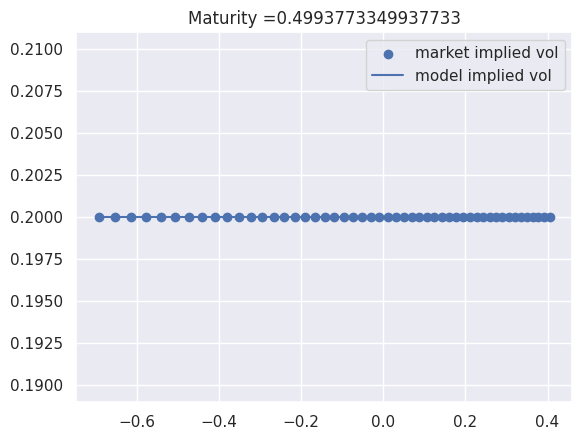

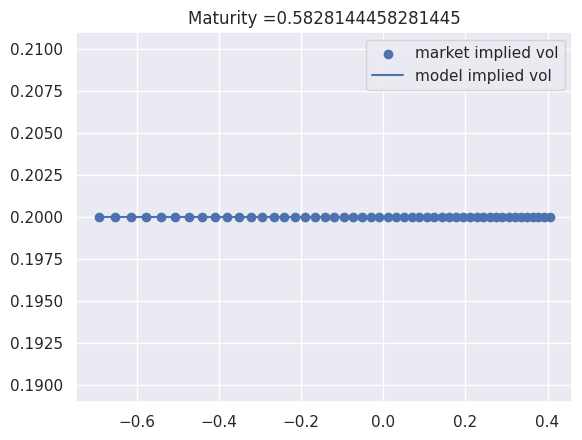

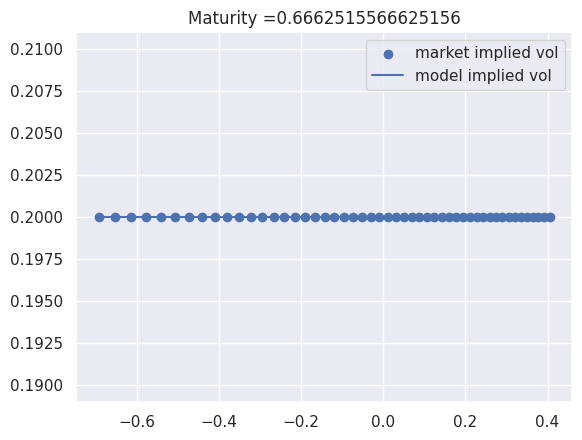

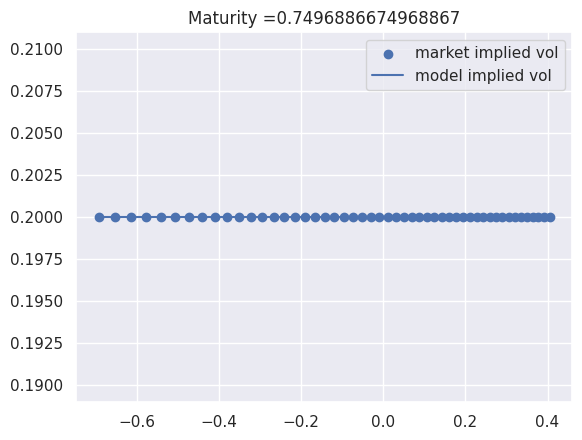

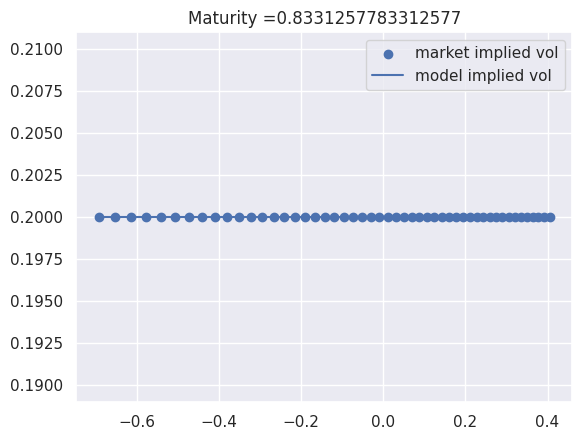

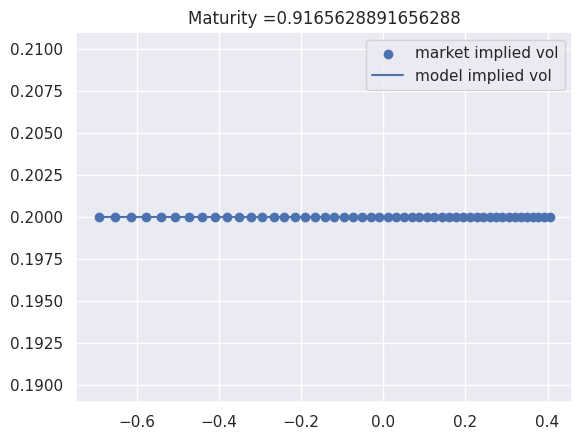

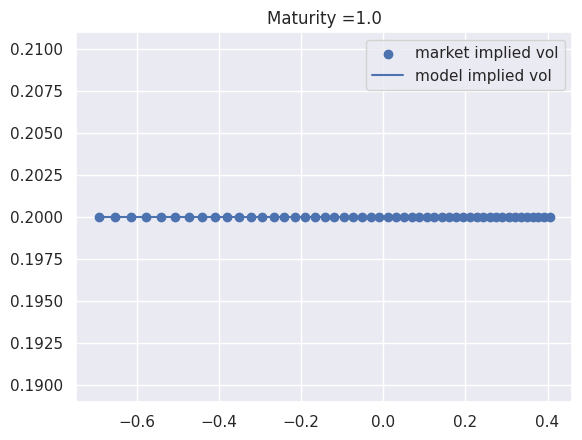

In [ ]:
method_name = "Nelder-Mead"
for ttm in sorted(data_calls.Maturity.unique()):
  if ttm < 0.0191:
    continue
  else:
    moneyness = data_calls[data_calls.Maturity == ttm].Log_Moneyness
    ivs = data_calls[data_calls.Maturity == ttm].IV
    # weights = data_calls[data_calls.Maturitu == ttm]
    a,b,rho,m,s = Calibration((ivs**2),moneyness,[0.05,0.2],"Nelder-Mead",10)
    m_vec = np.linspace(min(moneyness),max(moneyness),50)
    iv_vec = np.sqrt(SVI(m_vec,a,b,rho,m,s))
    plt.title("Maturity ="+str(ttm))
    plt.scatter(moneyness,ivs,label = "market implied vol")
    plt.plot(m_vec,iv_vec,label = "model implied vol")
    plt.legend(loc = "best")
    plt.show()

In [ ]:
def params_new(ttm,init_ms):
  data_calls_filtered = data_calls[data_calls.Maturity == ttm]
  moneyness = data_calls_filtered.Log_Moneyness
  iv = data_calls_filtered.IV
  if ttm < 0.0191:
    pass
  else:
    a,b,rho,m,s = Calibration(((iv)**2),moneyness,init_ms,"Nelder-Mead",10)
    return [a,b,rho,m,s]

In [ ]:
def params_skew(data_proc,number_parameters = 5):
  # This function fits each skew using a map function and need to be stored
  # data : processed data
  # number_parameters : number of parameters of fitting model ( 5 for SVI )
  # Result : Matrix (number of maturities in the market, number of model parameters + 1)
  # First column in the matrix is maturities in the market, the rest are vector of parameters across these maturities

  sorted_ttm_vec = data_calls.Maturity.sort_values().unique()
  index = np.searchsorted(sorted_ttm_vec, 0.019, side='right')
  sorted_ttm_vec= sorted_ttm_vec[index:]
  params_matrix = np.zeros((len(sorted_ttm_vec),number_parameters+1))
  params_matrix[:,0] = sorted_ttm_vec
  params_list = []
  for i in range(len(sorted_ttm_vec)):
    ttm = sorted_ttm_vec[i]
    params_list.append(params_new(ttm,[0.05,0.2]))
  params_matrix[:,1:] = np.array(params_list)
  return params_matrix

In [ ]:
params_matrix = params_skew(data_calls,number_parameters = 5)

In [ ]:
def implied_vol(m,t,params_matrix):
  # moneyness : strike price given by the user: ln(K/S)
  # t : Time to expiry given by the user in days
  # params_matrix : matrix of optimal parameters across market maturities
  ttm_vec = params_matrix[:,0]
  y = SVI(m,params_matrix[:,1],params_matrix[:,2],params_matrix[:,3],params_matrix[:,4],params_matrix[:,5]) # vector of implied vol needed for interpolation
  x = params_matrix[:,0]
  ys = x*y # total variance
  x = np.insert(x,0,0)
  ys = np.insert(ys,0,0)
  cs = interp1d(x,ys,fill_value = "extrapolate")
  lin = cs(t)
  final_iv = np.array(np.sqrt(lin/t))
  return final_iv,lin

#Computing the local variance from implied variance by finite difference on the interpolated surface :

In [ ]:
def compute_local_volatility(K,T,params_matrix, S_ref):

  m = np.log(K/S_ref)
  t = T/365
  epsilon = 1e-3
  const = implied_vol(m,t,params_matrix)[1]
  const_2 = implied_vol(m+epsilon,t,params_matrix)[1]
  def SVIt(m,t,params_matrix):
    SVIt = (implied_vol(m,t+epsilon,params_matrix)[1] - const)/epsilon
    return SVIt
  def SVIm(m,t,params_matrix):
    SVIm = ( const_2- const)/epsilon
    return SVIm
  def SVImm(m,t,params_matrix):
    SVImm = (const_2 - 2*const + implied_vol(m-epsilon,t,params_matrix)[1])/(epsilon*epsilon)
    return SVImm
  def g(m, t, params_matrix):
      w = const
      w1 = SVIm(m, t, params_matrix)
      w2 = SVImm(m, t, params_matrix)
      return (1.-0.5*m*w1/w)*(1.-0.5*m*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
  return np.sqrt(SVIt(m,t,params_matrix) / g(m,t,params_matrix))

In [ ]:
S_ref = 100
K = 140
T = 50
print('Local volatility for a constant vol of 0.2 : ')
compute_local_volatility(K,T,params_matrix, S_ref)

Local volatility for a constant vol of 0.2 : 


0.20000000000000026

In [ ]:
def LV_from_IV(K,T,params_matrix, S_ref):
  LV = compute_local_volatility(K,T,params_matrix, S_ref)
  return LV

In [ ]:
LV_from_IV(90,70,params_matrix,100)

0.20000000000000026

Pricing An autocall with Local volatility

In [ ]:
matrix = np.loadtxt('/content/matrix.csv', delimiter=',')

In [ ]:
matrix

array([[-0.5197861 ,  1.98781967,  1.58961203, ...,  1.70849493,
        -0.83049074,  0.32533285],
       [ 0.23755134, -0.9769254 , -1.96371093, ...,  1.72135399,
        -0.57420017, -0.11727397],
       [ 0.31853061, -1.66598194, -0.75082113, ...,  0.96078658,
         0.73823321, -1.7761808 ],
       ...,
       [ 0.31483239, -0.43250412, -0.15473789, ...,  0.60480666,
        -0.06469881, -1.80435254],
       [ 0.34256408,  1.82901211,  0.4851626 , ..., -1.91024821,
         1.53613354,  0.70295683],
       [-0.16443484, -0.28502587, -0.02630234, ...,  0.99884101,
         2.41954101,  0.28942429]])

In [ ]:
def simulate_stock(S0,T,N,r,d,sigma_initial):
  '''
  S0 : Initial stock price
  T : Maturity of the autocall
  N : number of paths
  r : interest rate
  sigma : volatility
  d : dividend
  Output : A matrix of N lines and 365*T columns presenting the evolution of the stock price
  '''
  S0_vec = np.full(N,S0)
  S_matrix = np.zeros((N,365*T))
  S_matrix[:,0] = S0_vec
  timestep = 1/(T*365)
  for i in range(S_matrix.shape[1]-1):
    # rand_vec = np.random.normal(0,1,size=N)
    rand_vec = matrix[:,i]
    if i == 0:
      S_matrix[:,i+1] = S_matrix[:,i] * np.exp(((r-d-(sigma_initial**2)/2)*timestep + sigma_initial*np.sqrt(timestep) * rand_vec))
    else :
      maturity = i*timestep*365
      for j in range(S_matrix.shape[0]):
        LV = LV_from_IV(S_matrix[j,i],maturity,params_matrix, S0)
        S_matrix[j,i+1] = S_matrix[j,i] * np.exp(((r-d-(LV**2)/2)*timestep + LV*np.sqrt(timestep) * rand_vec[j]))
  return S_matrix

In [ ]:
S0 = 100
T = 3
N = 10
r = 0
d = 0
sigma_initial = 0.2
S_matrix = simulate_stock(S0,T,N,r,d,sigma_initial)

In [ ]:
def plot_stock_path(matrice,T):
  x_axis = np.linspace(0,T,365*T)
  for i in range(matrice.shape[0]):
    plt.plot(x_axis,matrice[i,:])
  plt.show()

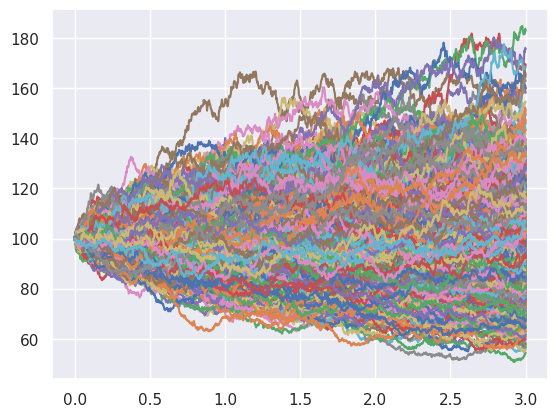

In [ ]:
plot_stock_path(S_matrix,3)

In [ ]:
def compute_payoff(S0,T,N,freq_obs,BP,AT,coupon):
  '''
  AT will be a list of Autocall barriers each corresponding to an observation date
  coupon : for now a scaler
  '''

  step_size = (T * 365)/freq_obs
  obs_dates = [int((k+1)*step_size- 1) for k in range(freq_obs)]
  state_matrix = np.ones((N,freq_obs))
  evaluation_matrix = S_matrix[:,obs_dates]/S0
  # evaluation_matrix = np.array([[1.20371427, 1.12631269, 1.24810408,1.20371427, 1.12631269, 1.24810408,1.20371427, 1.12631269, 1.24810408,1.20371427, 1.12631269, 1.24810408],
  #      [0.97 ,0.93945793,0.97,1.098478455 , 1.098478455, 0.93945793,0.97 , 1.098478455, 0.93945793,0.97 , 1.098478455, 0.93945793],
  #      [0.97558902, 0.19117429, 0.085,0.97558902, 0.19117429, 0.085,0.97558902, 0.19117429, 0.085,0.97558902, 0.19117429, 1.085],
  #      [0.90538683, 0.86595771, 0.79177789,0.90538683, 0.86595771, 0.79177789,0.90538683, 0.86595771, 0.79177789,0.90538683, 0.86595771, 0.79177789],
  #      [0.94335983, 0.99043135, 0.85,0.94335983, 0.99043135, 0.85,0.94335983, 0.99043135, 0.85,0.94335983, 0.99043135, 0.85]])
  payoff_coupon_matrix = np.zeros((N,freq_obs))
  payoff_kg_matrix = np.zeros((N,freq_obs))
  obs = 0
  while obs < freq_obs:
    for i in range(evaluation_matrix.shape[0]):
      if evaluation_matrix[i,obs]>=AT[obs]:
        payoff_coupon_matrix[i,obs] = ((1+obs)*T/freq_obs)*coupon*np.min(state_matrix[i,:])
        payoff_kg_matrix[i,obs] = 1*np.min(state_matrix[i,:])
        state_matrix[i,obs] = 0
      else :
        payoff_coupon_matrix[i,obs] = 0
        payoff_kg_matrix[i,obs] = 0
    obs = obs +1

  #Final date
  comparison_AT = (evaluation_matrix[:, -1] >= AT[freq_obs-1])
  comparison_BP = (evaluation_matrix[:, -1] < AT[freq_obs-1]) & (evaluation_matrix[:, -1] >= BP)

  payoff_coupon_matrix[:,-1] = np.where(comparison_AT,(freq_obs*T/freq_obs)*coupon*np.min(state_matrix[:,:freq_obs - 1],axis=1),0)
  payoff_kg_matrix[:,-1] = np.where(comparison_AT, 1 * np.min(state_matrix[:, :freq_obs - 1],axis=1), 0)
  payoff_kg_matrix[:,-1] = np.where(comparison_BP, 1 * np.min(state_matrix[:, :freq_obs - 1],axis=1), payoff_kg_matrix[:,-1])
  payoff_kg_matrix[:,-1] = np.where(~comparison_AT & ~comparison_BP, 1*np.min(state_matrix[:,:freq_obs - 1],axis=1), payoff_kg_matrix[:,-1])
  payoff_coupon_matrix[:,-1] = np.where(~comparison_AT & ~comparison_BP, -(1-evaluation_matrix[:, -1])*np.min(state_matrix[:,:freq_obs - 1],axis=1),payoff_coupon_matrix[:,-1])
  payoff_matrix = payoff_coupon_matrix + payoff_kg_matrix

  # print(payoff_coupon_matrix)
  # print(payoff_kg_matrix)
  return evaluation_matrix,payoff_coupon_matrix,payoff_kg_matrix,state_matrix,payoff_matrix

In [ ]:
freq_obs = 3
coupon = 0.0
N = 10
BP = 1
# N=5
# for AT in [[0,0,0,0,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,1,1],[100,100,100,100,100,100,100,100,100,100,100,100]]:
#   for BP in [0,1,100]:
#     print(AT,BP)
#     eval_matrix,payoff_coupon_matrix,payoff_kg_matrix,state_matrix,payoff_matri = compute_payoff(S0,T,N,freq_obs,BP,AT,coupon)
BP = 1
# for AT in [[0,0,0,0,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,1,1],[100,100,100,100,100,100,100,100,100,100,100,100]]:
#   print(AT,BP)
#   eval_matrix,payoff_coupon_matrix,payoff_kg_matrix,state_matrix,payoff_matri = compute_payoff(S0,T,N,freq_obs,BP,AT,coupon)
AT = [1,1,1]
eval_matrix,payoff_coupon_matrix,payoff_kg_matrix,state_matrix,payoff_matri = compute_payoff(S0,T,N,freq_obs,BP,AT,coupon)

In [ ]:
np.mean(payoff_kg_matrix,axis = 0)

array([0.471, 0.131, 0.398])

In [ ]:
def compute_price(notional,matrice,r,T,freq_obs):
  price = 0
  # discount_rates = get_forward_riskless_rates(T,freq_obs)
  discount_rates = np.zeros(3)
  for i in range(freq_obs):
    price = price + np.mean(matrice[:,i]) * np.exp(-discount_rates[i]*T*(i+1)/freq_obs)
  return price*notional

In [ ]:
notional = 100
compute_price(notional,payoff_matri,r,T,freq_obs)

93.93473666337862

For the same parameters in constant vol, we find price = 92.59 and the mean of the payoff kg matrix for each observation date array([0.44, 0.15, 0.41])
so the results are pretty close

# Working with a smile dump matrix

In [ ]:
93.80696045099309 Local vol

94.64182654648721 const vol

In [ ]:
const vol 93.93
local vol